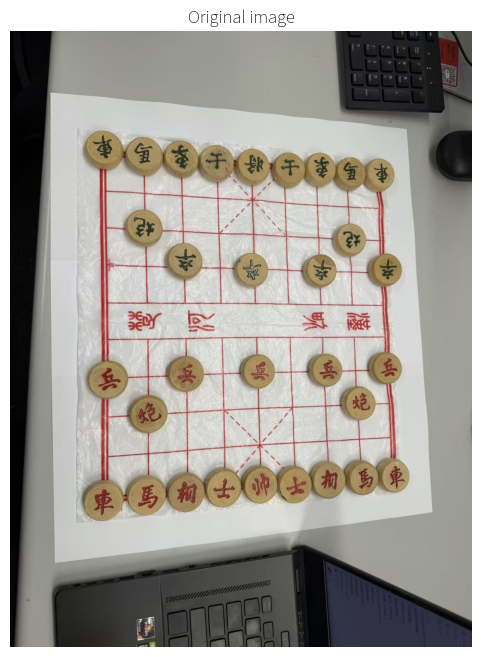

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams['font.sans-serif'] = ['Noto Sans SC'] 
plt.rcParams['axes.unicode_minus'] = False 

IMAGE_PATH = Path("./data/train_cnn2_image/01.jpg")
FEATURE_EXTRACT = Path("./blank_temp.jpg")
DATA_DIR = IMAGE_PATH.parent

assert IMAGE_PATH.exists(), f"The image path does not exist.: {IMAGE_PATH}"
assert FEATURE_EXTRACT.exists(), f"Feature extraction template diagram does not exist: {FEATURE_EXTRACT}"

image_bgr = cv2.imread(str(IMAGE_PATH))
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 8))
plt.imshow(image_rgb)
plt.axis("off")
plt.title("Original image")
plt.show()


Detected 31 candidate line segments


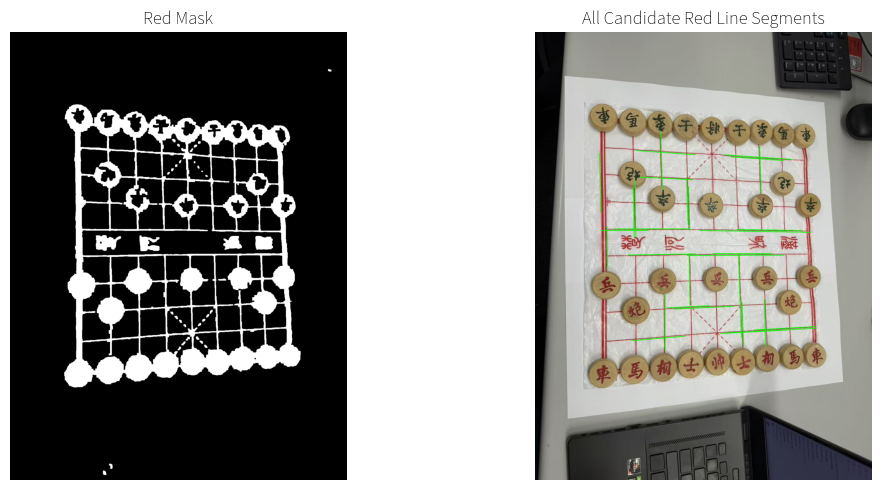

In [4]:
from dataclasses import dataclass

@dataclass
class LineSegment:
    p1: tuple
    p2: tuple
    angle: float
    length: float


def extract_red_segments(image_bgr: np.ndarray):
    RED_MIN = 100
    DIFF_MIN = 15

    b, g, r = cv2.split(image_bgr)
    r = r.astype(np.int16)
    g = g.astype(np.int16)
    b = b.astype(np.int16)

    mask = (
        (r > RED_MIN) &
        ((r - g) > DIFF_MIN) &
        ((r - b) > DIFF_MIN)
    ).astype(np.uint8) * 255

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)

    edges = cv2.Canny(mask, 60, 160, apertureSize=3)
    raw = cv2.HoughLinesP(
        edges,
        rho=1,
        theta=np.pi / 180,
        threshold=120,
        minLineLength=image_bgr.shape[1] // 8,
        maxLineGap=30,
    )

    segments = []
    if raw is not None:
        for x1, y1, x2, y2 in raw.reshape(-1, 4):
            p1, p2 = (int(x1), int(y1)), (int(x2), int(y2))
            length = float(np.hypot(x2 - x1, y2 - y1))
            angle = float(np.arctan2(y2 - y1, x2 - x1))
            angle = (angle + np.pi) % np.pi  # Map to [0, π)
            if angle > np.pi / 2:
                angle -= np.pi  # [-π/2, π/2)
            segments.append(LineSegment(p1, p2, angle, length))

    return mask, segments


red_mask, segments = extract_red_segments(image_bgr)
print(f"Detected {len(segments)} candidate line segments")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(red_mask, cmap='gray')
plt.title('Red Mask')
plt.axis('off')

canvas = image_bgr.copy()
for seg in segments:
    cv2.line(canvas, seg.p1, seg.p2, (0, 255, 0), 2)

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
plt.title('All Candidate Red Line Segments')
plt.axis('off')
plt.tight_layout()
plt.show()


Number of horizontal line segments: 18
Number of vertical line segments: 13


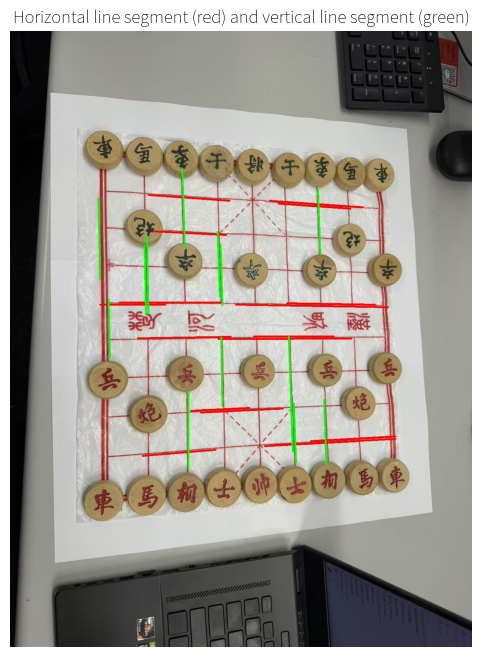

In [6]:
ANGLE_TOL_DEG = 40
MIN_LENGTH = image_bgr.shape[1] * 0.1

horizontal_segments = []
vertical_segments = []

for seg in segments:
    if seg.length < MIN_LENGTH:
        continue
    angle_deg = np.degrees(seg.angle)
    if abs(angle_deg) <= ANGLE_TOL_DEG:
        horizontal_segments.append(seg)
    elif abs(abs(angle_deg) - 90.0) <= ANGLE_TOL_DEG:
        vertical_segments.append(seg)

print(f"Number of horizontal line segments: {len(horizontal_segments)}")
print(f"Number of vertical line segments: {len(vertical_segments)}")

canvas = image_bgr.copy()
for seg in horizontal_segments:
    cv2.line(canvas, seg.p1, seg.p2, (0, 0, 255), 3)
for seg in vertical_segments:
    cv2.line(canvas, seg.p1, seg.p2, (0, 255, 0), 3)

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
plt.title('Horizontal line segment (red) and vertical line segment (green)')
plt.axis('off')
plt.show()



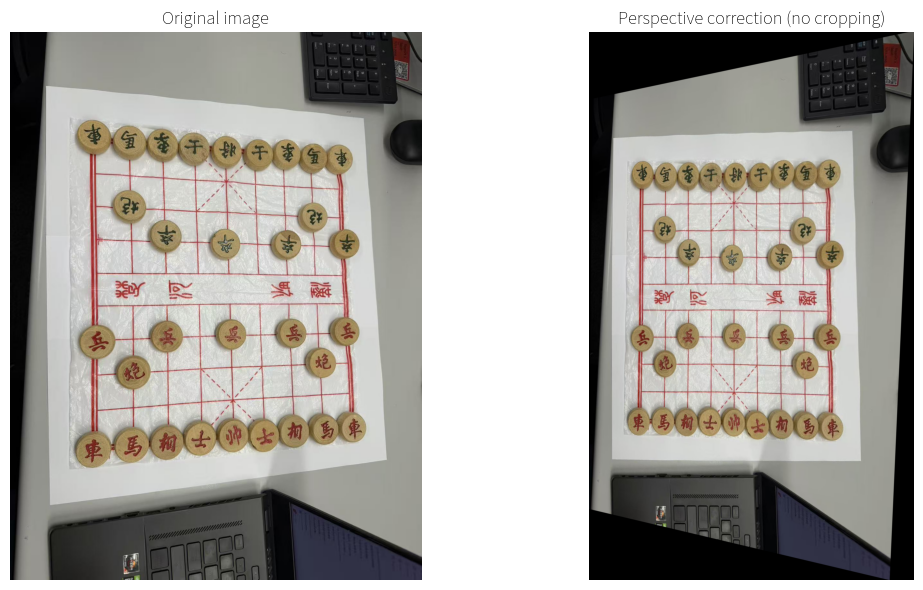

In [7]:
def line_from_segment(seg):
    x1, y1 = seg.p1
    x2, y2 = seg.p2
    a = y1 - y2
    b = x2 - x1
    c = x1 * y2 - x2 * y1
    return np.array([a, b, c], dtype=np.float32)


def intersect(line1, line2):
    a1, b1, c1 = line1
    a2, b2, c2 = line2
    det = a1 * b2 - a2 * b1
    if abs(det) < 1e-6:
        return None
    x = (b1 * c2 - b2 * c1) / det
    y = (c1 * a2 - c2 * a1) / det
    return np.array([x, y], dtype=np.float32)


if len(horizontal_segments) < 2 or len(vertical_segments) < 2:
    raise RuntimeError("Insufficient number of horizontal or vertical lines to enable correction.")

horizontal_sorted = sorted(horizontal_segments, key=lambda seg: (seg.p1[1] + seg.p2[1]) / 2)
vertical_sorted = sorted(vertical_segments, key=lambda seg: (seg.p1[0] + seg.p2[0]) / 2)

# Extract the top, bottom, left and right boundary lines
top_seg = horizontal_sorted[0]
bottom_seg = horizontal_sorted[-1]
left_seg = vertical_sorted[0]
right_seg = vertical_sorted[-1]

top_line = line_from_segment(top_seg)
bottom_line = line_from_segment(bottom_seg)
left_line = line_from_segment(left_seg)
right_line = line_from_segment(right_seg)

corners = [
    intersect(top_line, left_line),
    intersect(top_line, right_line),
    intersect(bottom_line, right_line),
    intersect(bottom_line, left_line),
]

if any(pt is None for pt in corners):
    raise RuntimeError("Corner point solution failed")

corners = np.stack(corners).astype(np.float32)

height, width = image_bgr.shape[:2]
target = np.float32([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]])

H0 = cv2.getPerspectiveTransform(corners, target)

orig_corners = np.float32([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]])
warped_corners = cv2.perspectiveTransform(orig_corners.reshape(1, 4, 2), H0)[0]
min_xy = warped_corners.min(axis=0)
max_xy = warped_corners.max(axis=0)

translate = np.array([
    [1, 0, -min_xy[0]],
    [0, 1, -min_xy[1]],
    [0, 0, 1]
], dtype=np.float32)

full_H = translate @ H0
out_size = (
    int(np.ceil(max_xy[0] - min_xy[0])),
    int(np.ceil(max_xy[1] - min_xy[1]))
)

warped_full = cv2.warpPerspective(image_bgr, full_H, out_size)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
plt.title('Original image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(warped_full, cv2.COLOR_BGR2RGB))
plt.title('Perspective correction (no cropping)')
plt.axis('off')
plt.tight_layout()
plt.show()



Blank board size: 932x932
Extracted features: 2401


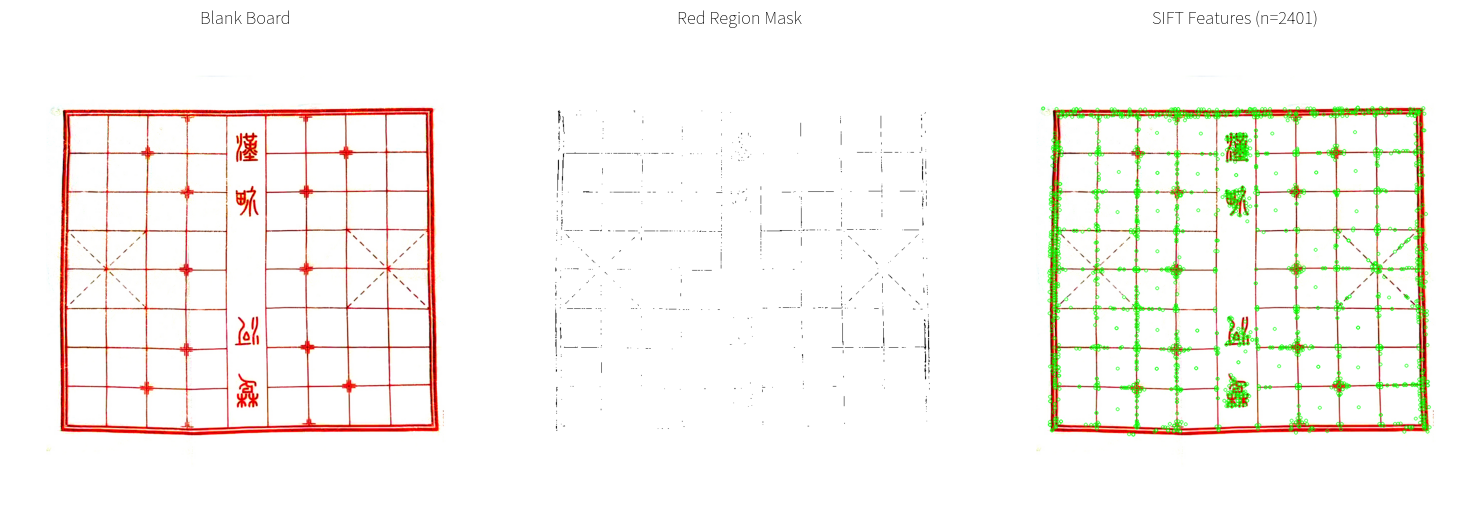

In [8]:
# Cell 4: Extract features from blank board (using SIFT to handle deformation)

# Read blank board
template = cv2.imread(str(FEATURE_EXTRACT))
h_t, w_t = template.shape[:2]
print(f"Blank board size: {w_t}x{h_t}")

# Extract red region mask
r = cv2.split(template)[2]
_, mask = cv2.threshold(r, 100, 255, cv2.THRESH_BINARY)

# Use SIFT (increase number of features, lower threshold)
sift = cv2.SIFT_create(
    nfeatures=5000,           # Increase to 5000 features
    contrastThreshold=0.03,   # Lower contrast threshold (default 0.04)
    edgeThreshold=15          # Increase edge threshold (default 10), reduce edge noise
)
kp_template, desc_template = sift.detectAndCompute(template, mask=mask)

print(f"Extracted features: {len(kp_template)}")

# Create FLANN matcher (for SIFT)
flann = cv2.FlannBasedMatcher(dict(algorithm=1, trees=8), dict(checks=128))

# Visualization
vis = cv2.drawKeypoints(template, kp_template, None, color=(0,255,0), flags=0)
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(cv2.cvtColor(template, cv2.COLOR_BGR2RGB))
plt.title('Blank Board')
plt.axis('off')
plt.subplot(132)
plt.imshow(mask, cmap='gray')
plt.title('Red Region Mask')
plt.axis('off')
plt.subplot(133)
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title(f'SIFT Features (n={len(kp_template)})')
plt.axis('off')
plt.tight_layout()
plt.show()


Test image: 05.jpg
Size after perspective transformation: 3898x4774
0°: Features=4034, Matches=234, Inliers=123
90°: Features=4026, Matches=255, Inliers=114
180°: Features=4055, Matches=237, Inliers=119
270°: Features=4050, Matches=247, Inliers=129

Best direction: 270°, Inlier count: 129


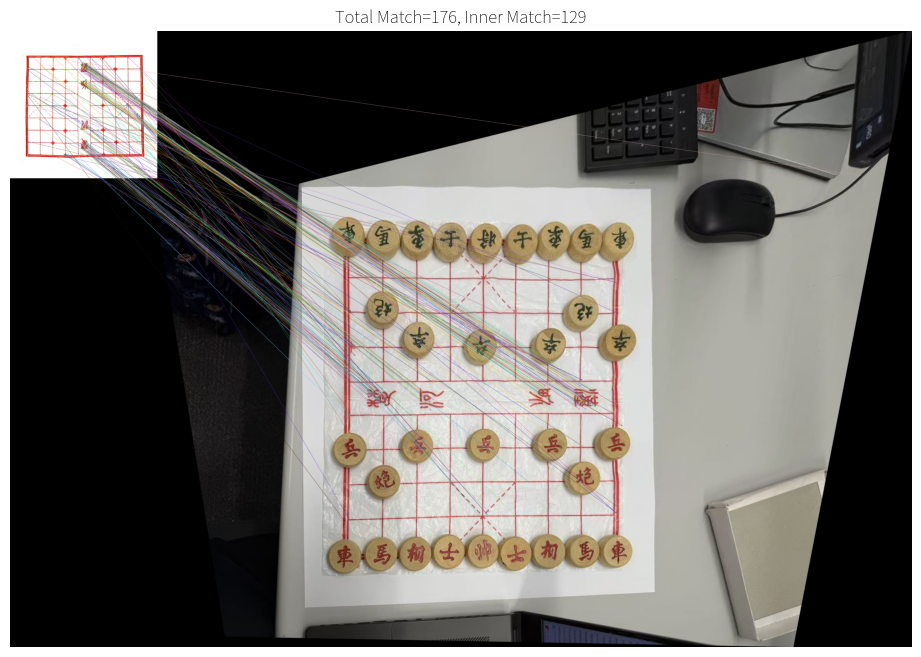

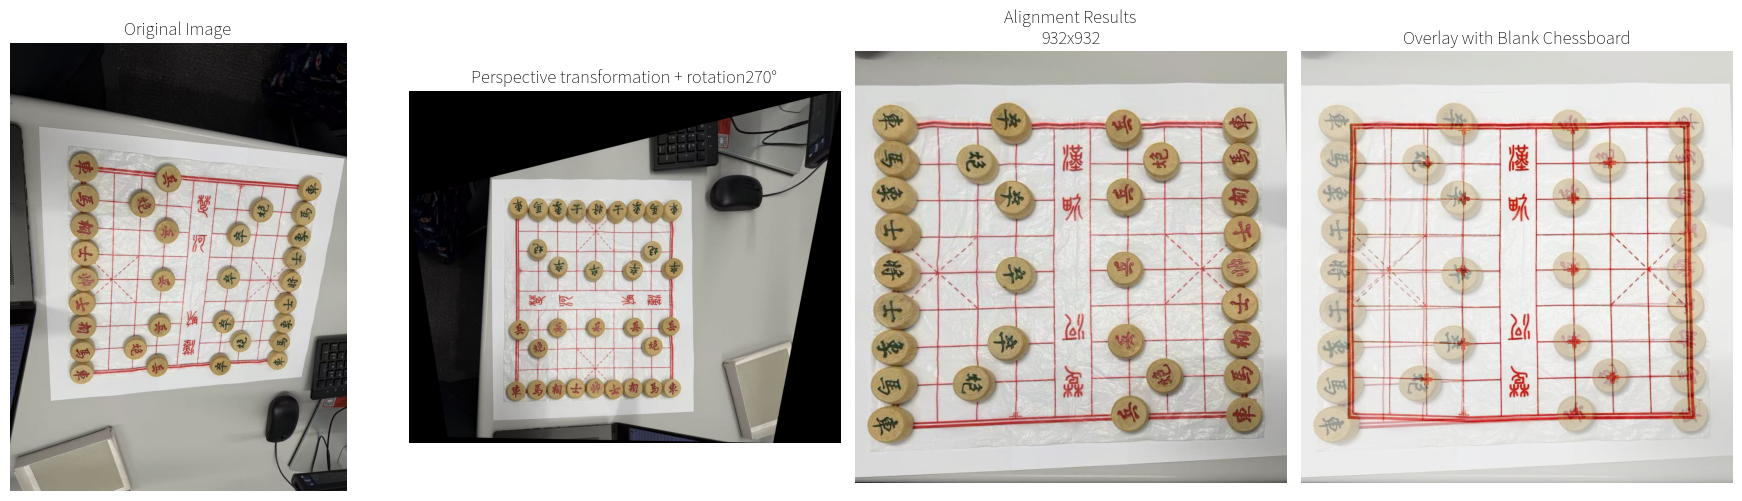

In [10]:
# Cell 5: Single image test - align to blank board

# Read test image
test_img_path = DATA_DIR / "05.jpg"
img = cv2.imread(str(test_img_path))
print(f"Test image: {test_img_path.name}")

# Step 1: Perspective transformation
red_mask, segments = extract_red_segments(img)
ANGLE_TOL_DEG = 40
MIN_LENGTH = img.shape[1] * 0.1

h_segs = [s for s in segments if s.length >= MIN_LENGTH and abs(np.degrees(s.angle)) <= ANGLE_TOL_DEG]
v_segs = [s for s in segments if s.length >= MIN_LENGTH and abs(abs(np.degrees(s.angle)) - 90) <= ANGLE_TOL_DEG]

if len(h_segs) < 2 or len(v_segs) < 2:
    raise ValueError("Insufficient red lines")

h_sorted = sorted(h_segs, key=lambda s: (s.p1[1] + s.p2[1]) / 2)
v_sorted = sorted(v_segs, key=lambda s: (s.p1[0] + s.p2[0]) / 2)

corners = [
    intersect(line_from_segment(h_sorted[0]), line_from_segment(v_sorted[0])),
    intersect(line_from_segment(h_sorted[0]), line_from_segment(v_sorted[-1])),
    intersect(line_from_segment(h_sorted[-1]), line_from_segment(v_sorted[-1])),
    intersect(line_from_segment(h_sorted[-1]), line_from_segment(v_sorted[0])),
]

corners = np.float32(corners)
h, w = img.shape[:2]
target = np.float32([[0, 0], [w-1, 0], [w-1, h-1], [0, h-1]])
H = cv2.getPerspectiveTransform(corners, target)
warped_corners = cv2.perspectiveTransform(target.reshape(1, 4, 2), H)[0]
min_xy = warped_corners.min(axis=0)
max_xy = warped_corners.max(axis=0)
translate = np.float32([[1, 0, -min_xy[0]], [0, 1, -min_xy[1]], [0, 0, 1]])
H_full = translate @ H
size = (int(np.ceil(max_xy[0] - min_xy[0])), int(np.ceil(max_xy[1] - min_xy[1])))
warped = cv2.warpPerspective(img, H_full, size)

print(f"Size after perspective transformation: {warped.shape[1]}x{warped.shape[0]}")

# Step 2: Test 4 directions, find best match
best_angle, best_inliers, best_H = 0, 0, None

for angle in [0, 90, 180, 270]:
    if angle == 90:
        rotated = cv2.rotate(warped, cv2.ROTATE_90_CLOCKWISE)
    elif angle == 180:
        rotated = cv2.rotate(warped, cv2.ROTATE_180)
    elif angle == 270:
        rotated = cv2.rotate(warped, cv2.ROTATE_90_COUNTERCLOCKWISE)
    else:
        rotated = warped
    
    # Extract features
    r_ch = cv2.split(rotated)[2]
    _, m = cv2.threshold(r_ch, 100, 255, cv2.THRESH_BINARY)
    kp, desc = sift.detectAndCompute(rotated, mask=m)
    
    if desc is None or len(desc) < 4:
        continue
    
    # Match (relax ratio test threshold)
    matches = flann.knnMatch(desc_template, desc, k=2)
    good = [m for m, n in matches if len([m, n]) == 2 and m.distance < 0.75 * n.distance]  # 0.7→0.75
    
    if len(good) < 4:
        continue
    
    # Calculate homography (relax RANSAC threshold)
    src_pts = np.float32([kp_template[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
    H_match, mask_h = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 8.0)  # 5.0→8.0
    inliers = int(mask_h.sum()) if mask_h is not None else 0
    
    print(f"{angle}°: Features={len(kp)}, Matches={len(good)}, Inliers={inliers}")
    
    if inliers > best_inliers:
        best_inliers = inliers
        best_angle = angle
        best_H = H_match

print(f"\nBest direction: {best_angle}°, Inlier count: {best_inliers}")

# Visualize matches for best direction
if best_angle == 90:
    best_rotated = cv2.rotate(warped, cv2.ROTATE_90_CLOCKWISE)
elif best_angle == 180:
    best_rotated = cv2.rotate(warped, cv2.ROTATE_180)
elif best_angle == 270:
    best_rotated = cv2.rotate(warped, cv2.ROTATE_90_COUNTERCLOCKWISE)
else:
    best_rotated = warped

r_ch = cv2.split(best_rotated)[2]
_, m = cv2.threshold(r_ch, 100, 255, cv2.THRESH_BINARY)
kp_best, desc_best = sift.detectAndCompute(best_rotated, mask=m)
matches_best = flann.knnMatch(desc_template, desc_best, k=2)
good_best = [m for m, n in matches_best if len([m, n]) == 2 and m.distance < 0.7 * n.distance]

# Draw matches
match_img = cv2.drawMatches(template, kp_template, best_rotated, kp_best, 
                            good_best[:250], None, flags=2)  # Only show first 250
plt.figure(figsize=(20, 8))
plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
plt.title(f'Total Match={len(good_best)}, Inner Match={best_inliers}')
plt.axis('off')
plt.show()

# Step 3: Apply best transformation
if best_angle == 90:
    warped = cv2.rotate(warped, cv2.ROTATE_90_CLOCKWISE)
elif best_angle == 180:
    warped = cv2.rotate(warped, cv2.ROTATE_180)
elif best_angle == 270:
    warped = cv2.rotate(warped, cv2.ROTATE_90_COUNTERCLOCKWISE)

# Key fix: compute inverse matrix!
# best_H is blank board → test image, need to reverse
H_inv = np.linalg.inv(best_H)
aligned = cv2.warpPerspective(warped, H_inv, (w_t, h_t))

# Visualization
plt.figure(figsize=(18, 5))
plt.subplot(141)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')
plt.subplot(142)
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.title(f'Perspective transformation + rotation{best_angle}°')
plt.axis('off')
plt.subplot(143)
plt.imshow(cv2.cvtColor(aligned, cv2.COLOR_BGR2RGB))
plt.title(f'Alignment Results\n{w_t}x{h_t}')
plt.axis('off')
plt.subplot(144)
overlay = cv2.addWeighted(aligned, 0.5, template, 0.5, 0)
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title('Overlay with Blank Chessboard')
plt.axis('off')
plt.tight_layout()
plt.show()


New method: Directly matching the original image to an empty chessboard
Test image: 013.jpg
Original image dimensions: 1280x1707
0°: Keypoints=4126, Matches=230, Inliers=107
90°: Keypoints=4100, Matches=232, Inliers=105
180°: Keypoints=4113, Matches=220, Inliers=102
270°: Keypoints=4133, Matches=236, Inliers=102

Best angle: 0°, Best inlier count: 107


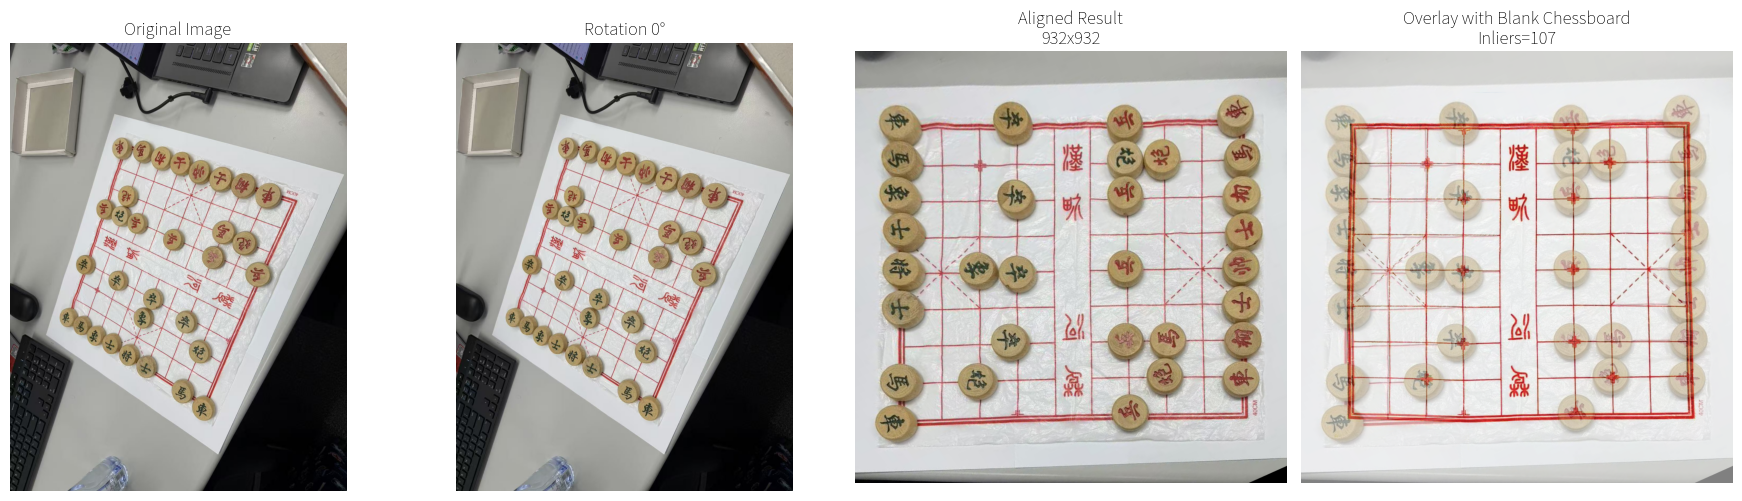

In [11]:
# Direct matching from the original image (bypassing perspective transformation)

print("=" * 60)
print("New method: Directly matching the original image to an empty chessboard")
print("=" * 60)

# Read test image
test_img_path = DATA_DIR / "013.jpg"
img_raw = cv2.imread(str(test_img_path))
print(f"Test image: {test_img_path.name}")
print(f"Original image dimensions: {img_raw.shape[1]}x{img_raw.shape[0]}")

# Step 1: Test the original image in 4 rotation directions
best_angle = 0
best_inliers = 0
best_H = None

for angle in [0, 90, 180, 270]:
    # Rotate the original image
    if angle == 90:
        rotated = cv2.rotate(img_raw, cv2.ROTATE_90_CLOCKWISE)
    elif angle == 180:
        rotated = cv2.rotate(img_raw, cv2.ROTATE_180)
    elif angle == 270:
        rotated = cv2.rotate(img_raw, cv2.ROTATE_90_COUNTERCLOCKWISE)
    else:
        rotated = img_raw

    # Extract features
    r_ch = cv2.split(rotated)[2]
    _, m = cv2.threshold(r_ch, 100, 255, cv2.THRESH_BINARY)
    kp, desc = sift.detectAndCompute(rotated, mask=m)

    if desc is None or len(desc) < 4:
        print(f"{angle}°: Not enough feature points.")
        continue

    # Feature matching
    matches = flann.knnMatch(desc_template, desc, k=2)
    good = [m for m, n in matches if len([m, n]) == 2 and m.distance < 0.75 * n.distance]

    if len(good) < 4:
        print(f"{angle}°: Not enough matching points.")
        continue

    # Compute homography
    src_pts = np.float32([kp_template[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
    H, mask_h = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 10.0)  # RANSAC threshold 10.0
    inliers = int(mask_h.sum()) if mask_h is not None else 0

    print(f"{angle}°: Keypoints={len(kp)}, Matches={len(good)}, Inliers={inliers}")

    if inliers > best_inliers:
        best_inliers = inliers
        best_angle = angle
        best_H = H

print(f"\nBest angle: {best_angle}°, Best inlier count: {best_inliers}")

# Step 2: Apply the transformation
if best_inliers < 10:
    print("Matching failed, not enough inliers.")
else:
    # Rotate to the best angle
    if best_angle == 90:
        img_rotated = cv2.rotate(img_raw, cv2.ROTATE_90_CLOCKWISE)
    elif best_angle == 180:
        img_rotated = cv2.rotate(img_raw, cv2.ROTATE_180)
    elif best_angle == 270:
        img_rotated = cv2.rotate(img_raw, cv2.ROTATE_90_COUNTERCLOCKWISE)
    else:
        img_rotated = img_raw

    # Directly align to the blank chessboard (inverse homography)
    H_inv = np.linalg.inv(best_H)
    aligned = cv2.warpPerspective(img_rotated, H_inv, (w_t, h_t))

    # Visualization
    plt.figure(figsize=(18, 5))

    plt.subplot(141)
    plt.imshow(cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(142)
    plt.imshow(cv2.cvtColor(img_rotated, cv2.COLOR_BGR2RGB))
    plt.title(f'Rotation {best_angle}°')
    plt.axis('off')

    plt.subplot(143)
    plt.imshow(cv2.cvtColor(aligned, cv2.COLOR_BGR2RGB))
    plt.title(f'Aligned Result\n{w_t}x{h_t}')
    plt.axis('off')

    plt.subplot(144)
    overlay = cv2.addWeighted(aligned, 0.5, template, 0.5, 0)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title(f'Overlay with Blank Chessboard\nInliers={best_inliers}')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


In [12]:
# Cell: Batch Processing - Align and Crop All Images

# Create output directory
output_dir = DATA_DIR / "aligned_output"
output_dir.mkdir(exist_ok=True)

# Get all image files
image_files = sorted(DATA_DIR.glob("*.jpg")) + sorted(DATA_DIR.glob("*.png"))
image_files = [f for f in image_files if f.name != FEATURE_EXTRACT.name]

print(f"Commencing batch processing of {len(image_files)} images...")

# Statistics
success_count = 0
fail_count = 0
results = []

for idx, img_path in enumerate(image_files, 1):
    print(f"\r[{idx}/{len(image_files)}] Processing...", end="", flush=True)
    
    try:
        # Read image
        img_raw = cv2.imread(str(img_path))
        if img_raw is None:
            fail_count += 1
            results.append((img_path.name, False, 0, 0))
            continue
        
        # Test in 4 rotations
        best_angle = 0
        best_inliers = 0
        best_H = None
        
        for angle in [0, 90, 180, 270]:
            # Rotate
            if angle == 90:
                rotated = cv2.rotate(img_raw, cv2.ROTATE_90_CLOCKWISE)
            elif angle == 180:
                rotated = cv2.rotate(img_raw, cv2.ROTATE_180)
            elif angle == 270:
                rotated = cv2.rotate(img_raw, cv2.ROTATE_90_COUNTERCLOCKWISE)
            else:
                rotated = img_raw
            
            # Feature extraction
            r_ch = cv2.split(rotated)[2]
            _, m = cv2.threshold(r_ch, 100, 255, cv2.THRESH_BINARY)
            kp, desc = sift.detectAndCompute(rotated, mask=m)
            
            if desc is None or len(desc) < 4:
                continue
            
            # Matching
            matches = flann.knnMatch(desc_template, desc, k=2)
            good = [m for m, n in matches if len([m, n]) == 2 and m.distance < 0.75 * n.distance]
            
            if len(good) < 4:
                continue
            
            # Homography calculation
            src_pts = np.float32([kp_template[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
            dst_pts = np.float32([kp[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
            H, mask_h = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 10.0)
            inliers = int(mask_h.sum()) if mask_h is not None else 0
            
            if inliers > best_inliers:
                best_inliers = inliers
                best_angle = angle
                best_H = H
        
        # Check matching quality
        if best_inliers < 10:
            fail_count += 1
            results.append((img_path.name, False, best_inliers, best_angle))
            continue
        
        # Apply transformation
        if best_angle == 90:
            img_rotated = cv2.rotate(img_raw, cv2.ROTATE_90_CLOCKWISE)
        elif best_angle == 180:
            img_rotated = cv2.rotate(img_raw, cv2.ROTATE_180)
        elif best_angle == 270:
            img_rotated = cv2.rotate(img_raw, cv2.ROTATE_90_COUNTERCLOCKWISE)
        else:
            img_rotated = img_raw
        
        H_inv = np.linalg.inv(best_H)
        aligned = cv2.warpPerspective(img_rotated, H_inv, (w_t, h_t))
        
        # Save result
        output_path = output_dir / img_path.name
        cv2.imwrite(str(output_path), aligned)
        
        success_count += 1
        results.append((img_path.name, True, best_inliers, best_angle))
        
    except Exception as e:
        fail_count += 1
        results.append((img_path.name, False, 0, 0))

# Print statistics
print(f"\rProcessing complete! Success: {success_count}/{len(image_files)}, fail: {fail_count}/{len(image_files)}")


Commencing batch processing of 18 images...
[1/18] Processing...

Processing complete! Success: 18/18, fail: 0/18


In [13]:
# Board intersection points coordinates
board_points = np.array([
    [[114,165],[194,166],[275,163],[350,165],[428,167],[505,165],[586,163],[665,163],[747,163],[830,165]],
    [[115,240],[193,240],[272,240],[350,240],[430,240],[510,240],[585,240],[665,240],[747,240],[832,240]],
    [[110,320],[193,320],[270,320],[350,320],[430,320],[507,320],[588,320],[667,320],[747,320],[835,320]],
    [[110,395],[190,395],[270,395],[350,395],[430,395],[505,395],[585,395],[667,395],[750,395],[835,395]],
    [[110,470],[190,470],[270,470],[350,470],[430,470],[505,470],[585,470],[667,470],[750,470],[835,470]],
    [[110,545],[190,545],[270,545],[350,545],[430,545],[505,545],[585,545],[667,545],[750,545],[835,545]],
    [[110,620],[190,620],[270,620],[350,620],[430,620],[505,620],[585,620],[667,620],[750,620],[835,620]],
    [[110,705],[190,705],[270,705],[350,705],[430,705],[505,705],[585,705],[667,705],[750,705],[835,705]],
    [[110,790],[190,790],[270,790],[350,790],[430,790],[505,790],[585,790],[667,790],[750,790],[835,790]]
])

# Batch cropping
aligned_dir = DATA_DIR / "aligned_output"
crops_dir = DATA_DIR / "crops"
crops_dir.mkdir(exist_ok=True)

half = 62  # 125//2
total = 0

for img_path in sorted(aligned_dir.glob("*.jpg")):
    img = cv2.imread(str(img_path))
    if img is None:
        continue

    folder = crops_dir / img_path.stem
    folder.mkdir(exist_ok=True)

    for r in range(9):
        for c in range(10):
            x, y = board_points[r, c]
            crop = img[y - half : y + half + 1, x - half : x + half + 1]
            cv2.imwrite(str(folder / f"{img_path.stem}-{r+1}-{c+1}.jpg"), crop)
            total += 1

print(f"Completed! Generated {total} crops")


Completed! Generated 1620 crops


In [19]:
"""
Prediction using the retrained model on crops data.
Note: Please run train_with_crops.py first to train and save model weights before running this script.
"""

import os
import cv2
import numpy as np
import pandas as pd
import pickle
from nn_models import CNN
from major_2 import resize_and_pad

# Define class mappings
piece_names = ["bing", "che", "ma", "pao", "xiang", "shi", "jiang"]
colors = ["r", "g"]
valid_classes = [f"{piece}_{color}" for piece in piece_names for color in colors]
valid_classes.append("empty")

class_to_id = {class_name: idx for idx, class_name in enumerate(valid_classes)}
id_to_class = {idx: class_name for idx, class_name in enumerate(valid_classes)}
num_classes = len(valid_classes)

print("=" * 80)
print("Loading Model")
print("=" * 80)

# Load model architecture
model_dir = './model/CNN_01_018_retrained'
model_arch_path = os.path.join(model_dir, 'model_architecture.pkl')

if not os.path.exists(model_arch_path):
    print(f"Error: Model architecture file not found: {model_arch_path}")
    print("Please run train_with_crops.py first to train and save the model.")
    exit(1)

with open(model_arch_path, 'rb') as f:
    model_params = pickle.load(f)

# Build model
model = CNN(**model_params)
model.build(input_shape=[(None, 256, 256, 3)])
model.call(np.zeros((1, 256, 256, 3), dtype=np.float32))

# Load model weights
weights_path = os.path.join(model_dir, 'CNN_crops_retrained.weights.h5')
if not os.path.exists(weights_path):
    print(f"Warning: Weights file not found: {weights_path}")
    print("The model will use random weights (untrained).")
    print("Please run train_with_crops.py first to train the model.")
else:
    model.load_weights(weights_path)
    print(f"Model weights loaded from: {weights_path}")

print("Model loaded successfully!")

# Configuration: set board ID for prediction
board_id = '012'  # Change this to predict different boards

crops_dir = f'./data/train_cnn2_image/crops/{board_id}'
print(f"\nReading images from {crops_dir}...")

# Read and sort all cropped images
image_files = []
for r in range(1, 10):  # rows 1-9
    for c in range(1, 11):  # columns 1-10
        filename = f"{board_id}-{r}-{c}.jpg"
        filepath = os.path.join(crops_dir, filename)
        if os.path.exists(filepath):
            image_files.append((r, c, filepath))
        else:
            print(f"Warning: File {filename} not found")

print(f"Found {len(image_files)} image files")

# Load and preprocess images
images = []
positions = []
target_size = (256, 256)

print("Preprocessing images...")
for r, c, filepath in image_files:
    img = cv2.imread(filepath)
    if img is None:
        print(f"Warning: Unable to read {filepath}")
        continue

    # Convert color space
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize and pad to 256x256
    img = resize_and_pad(img, target_size)

    images.append(img)
    positions.append((r, c))

images = np.array(images, dtype=np.float32)
print(f"Preprocessing completed, image shape: {images.shape}")

# Predict with model
print("\nPredicting...")
y_prob = model.predict(images)
y_pred = np.argmax(y_prob, axis=1)
print("Prediction completed!")

# Generate results DataFrame
results = []
for i, (r, c) in enumerate(positions):
    pred_id = y_pred[i]
    pred_class = id_to_class[pred_id]
    pred_prob = y_prob[i][pred_id]

    results.append({
        'row': r,
        'col': c,
        'label': pred_class
    })

    # Display some prediction results
    if i < 10:
        print(f"  Position ({r},{c}): {pred_class} (Confidence: {pred_prob:.3f})")

# Create DataFrame and save
df_pred = pd.DataFrame(results)
df_pred = df_pred.sort_values(['row', 'col'])

output_csv = f'{board_id}_recognition_new_model.csv'
df_pred.to_csv(output_csv, index=False)
print(f"\nPrediction results have been saved to: {output_csv}")

# Read ground-truth (if available)
correct_csv = f'Correct_Xiangqi_board_layout_{board_id}.csv'
if os.path.exists(correct_csv):
    df_correct = pd.read_csv(correct_csv)
    print(f"\nReading ground-truth: {correct_csv}")

    # Compare results
    print("\n" + "="*60)
    print("Comparison results")
    print("="*60)

    # Merge DataFrames for comparison
    df_merged = df_pred.merge(df_correct, on=['row', 'col'], suffixes=('_pred', '_correct'))

    # Calculate accuracy
    correct_count = (df_merged['label_pred'] == df_merged['label_correct']).sum()
    total_count = len(df_merged)
    accuracy = correct_count / total_count * 100

    print(f"\nOverall statistics:")
    print(f"  Total positions: {total_count}")
    print(f"  Correct: {correct_count}")
    print(f"  Wrong: {total_count - correct_count}")
    print(f"  Accuracy rate: {accuracy:.2f}%")

    # Display incorrect positions
    errors = df_merged[df_merged['label_pred'] != df_merged['label_correct']]
    if len(errors) > 0:
        print(f"\nError details (Total {len(errors)} errors):")
        print("-" * 60)
        for idx, row in errors.iterrows():
            print(f"  Position ({row['row']},{row['col']}): Predicted={row['label_pred']}, Correct={row['label_correct']}")
    else:
        print("\nPerfect recognition! No errors! 🎉")

    # Per-class accuracy statistics
    print("\n" + "="*60)
    print("Per-class accuracy statistics")
    print("="*60)

    class_stats = {}
    for label in df_correct['label'].unique():
        correct_label = df_correct[df_correct['label'] == label]
        merged_label = df_merged[df_merged['label_correct'] == label]

        total = len(merged_label)
        correct = (merged_label['label_pred'] == merged_label['label_correct']).sum()
        acc = correct / total * 100 if total > 0 else 0

        class_stats[label] = {
            'total': total,
            'correct': correct,
            'accuracy': acc
        }

        print(f"{label:12s}: {correct:2d}/{total:2d} = {acc:6.2f}%")

    print("\n" + "="*60)
    print(f"Overall accuracy: {accuracy:.2f}%")
    print("="*60)
else:
    print(f"\nGround-truth file not found: {correct_csv}")
    print("Skipping accuracy comparison.")

print("\n" + "="*80)
print("Done!")
print("="*80)



Loading Model
Model weights loaded from: ./model/CNN_01_018_retrained\CNN_crops_retrained.weights.h5
Model loaded successfully!

Reading images from ./data/train_cnn2_image/crops/012...
Found 90 image files
Preprocessing images...
Preprocessing completed, image shape: (90, 256, 256, 3)

Predicting...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Prediction completed!
  Position (1,1): che_g (Confidence: 1.000)
  Position (1,2): empty (Confidence: 1.000)
  Position (1,3): empty (Confidence: 1.000)
  Position (1,4): bing_g (Confidence: 1.000)
  Position (1,5): empty (Confidence: 1.000)
  Position (1,6): empty (Confidence: 1.000)
  Position (1,7): bing_r (Confidence: 1.000)
  Position (1,8): empty (Confidence: 1.000)
  Position (1,9): empty (Confidence: 1.000)
  Position (1,10): che_r (Confidence: 1.000)

Prediction results have been saved to: 012_recognition_new_model.csv

Ground-truth file not found: Correct_Xiangqi_board_layout_012.csv
Skipping accuracy comparison.

Done!


Visualisation results saved to: Comparison_of_Recognition_Results.png


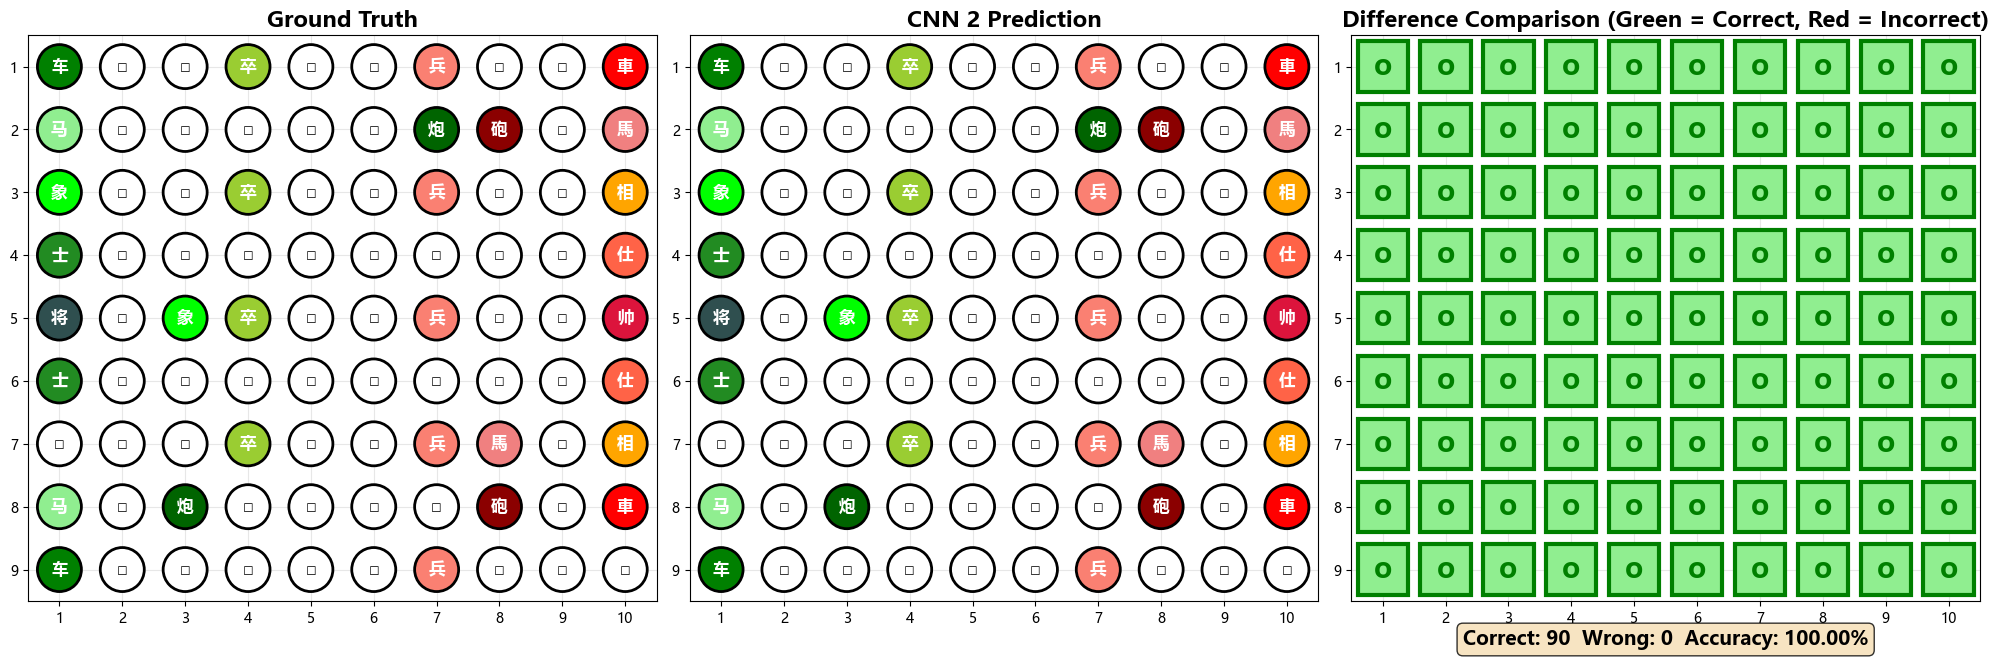


Distribution of Recognition Error Types:
Empty DataFrame
Columns: [label_correct, label_pred, count]
Index: []


In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Set font for Chinese piece names in icons/markers
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei', 'Arial']
plt.rcParams['axes.unicode_minus'] = False

# Read prediction and ground truth CSVs - FIXED PATHS
pred_csv_path = '012_recognition_new_model.csv'    # Generated by previous cell
correct_csv_path = './correct_layout_csv/Correct_Xiangqi_board_layout_012.csv'  # Fixed path

df_pred = pd.read_csv(pred_csv_path)
df_correct = pd.read_csv(correct_csv_path)

# Merge on board positions (row, col)
df_merged = df_pred.merge(df_correct, on=['row', 'col'], suffixes=('_pred', '_correct'))

# Create board visualisation
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# Color mapping for pieces
piece_colors = {
    'empty': 'white',
    'che_g': 'green', 'che_r': 'red',
    'ma_g': 'lightgreen', 'ma_r': 'lightcoral',
    'pao_g': 'darkgreen', 'pao_r': 'darkred',
    'xiang_g': 'lime', 'xiang_r': 'orange',
    'shi_g': 'forestgreen', 'shi_r': 'tomato',
    'jiang_g': 'darkslategray', 'jiang_r': 'crimson',
    'bing_g': 'yellowgreen', 'bing_r': 'salmon',
}

# Abbreviated character for each piece (Chinese kept, per prompt)
piece_abbr = {
    'empty': '□',
    'che_g': '车', 'che_r': '車',
    'ma_g': '马', 'ma_r': '馬',
    'pao_g': '炮', 'pao_r': '砲',
    'xiang_g': '象', 'xiang_r': '相',
    'shi_g': '士', 'shi_r': '仕',
    'jiang_g': '将', 'jiang_r': '帅',
    'bing_g': '卒', 'bing_r': '兵',
}

def draw_board(ax, df, title, label_col):
    ax.set_xlim(0.5, 10.5)
    ax.set_ylim(0.5, 9.5)
    ax.set_aspect('equal')
    ax.invert_yaxis()
    ax.set_xticks(range(1, 11))
    ax.set_yticks(range(1, 10))
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Draw pieces
    for _, row in df.iterrows():
        x, y = row['col'], row['row']
        label = row[label_col]
        color = piece_colors.get(label, 'gray')
        abbr = piece_abbr.get(label, '?')
        # Draw a circle for the piece
        circle = plt.Circle((x, y), 0.35, color=color, ec='black', linewidth=2, zorder=2)
        ax.add_patch(circle)
        # Show Chinese symbol
        text_color = 'black' if label == 'empty' else 'white'
        ax.text(x, y, abbr, ha='center', va='center',
                fontsize=12, fontweight='bold', color=text_color, zorder=3)

def draw_diff_board(ax, df):
    ax.set_xlim(0.5, 10.5)
    ax.set_ylim(0.5, 9.5)
    ax.set_aspect('equal')
    ax.invert_yaxis()
    ax.set_xticks(range(1, 11))
    ax.set_yticks(range(1, 10))
    ax.set_title('Difference Comparison (Green = Correct, Red = Incorrect)', fontsize=16, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    correct_count = 0
    error_count = 0
    # Show discrepancies
    for _, row in df.iterrows():
        x, y = row['col'], row['row']
        pred = row['label_pred']
        correct = row['label_correct']
        is_correct = pred == correct
        if is_correct:
            correct_count += 1
            color = 'lightgreen'
            marker = 'o'
            ec = 'green'
        else:
            error_count += 1
            color = 'lightcoral'
            marker = 'x'
            ec = 'red'
        # Draw a rectangle highlighting the cell
        rect = mpatches.Rectangle((x-0.4, y-0.4), 0.8, 0.8, 
                                  facecolor=color, edgecolor=ec, linewidth=3, zorder=2)
        ax.add_patch(rect)
        # Show marker (o or x)
        ax.text(x, y, marker, ha='center', va='center',
                fontsize=20, fontweight='bold', color=ec, zorder=3)

    # Show accuracy statistics
    accuracy = correct_count / (correct_count + error_count) * 100 if (correct_count + error_count) > 0 else 0
    ax.text(5.5, 10.2, f'Correct: {correct_count}  Wrong: {error_count}  Accuracy: {accuracy:.2f}%',
            ha='center', fontsize=14, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Draw three board plots: correct (ground truth), prediction, and difference
draw_board(axes[0], df_merged, 'Ground Truth', 'label_correct')
draw_board(axes[1], df_merged, 'CNN 2 Prediction', 'label_pred')
draw_diff_board(axes[2], df_merged)

plt.tight_layout()
plt.savefig('Comparison_of_Recognition_Results.png', dpi=150, bbox_inches='tight')
print("Visualisation results saved to: Comparison_of_Recognition_Results.png")
plt.show()

# Error type confusion statistics
print("\n" + "="*80)
print("Distribution of Recognition Error Types:")
print("="*80)
errors = df_merged[df_merged['label_pred'] != df_merged['label_correct']]
error_types = errors.groupby(['label_correct', 'label_pred']).size().reset_index(name='count')
error_types = error_types.sort_values('count', ascending=False)
print(error_types.to_string(index=False))
